### Read files

In [1]:
import glob, re
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import *

data = {
    #visitors
    'tra': pd.read_csv('./input/air_visit_data.csv',parse_dates=["visit_date"]),
    #reservations
    'ar': pd.read_csv('./input/air_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    'hr': pd.read_csv('./input/hpg_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    #store info
    'as': pd.read_csv('./input/air_store_info.csv'),
    'hs': pd.read_csv('./input/hpg_store_info.csv'),
    #air<->hpg
    'id': pd.read_csv('./input/store_id_relation.csv'),
    #days
    'hol': pd.read_csv('./input/date_info.csv',parse_dates=["calendar_date"]), #.rename(columns={'calendar_date':'visit_date'})
    #
    'tes': pd.read_csv('./input/sample_submission.csv'),
    }

/home/baruselli/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/baruselli/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/baruselli/anaconda3/lib/python3.5/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", Deprecat

In [2]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(np.log(y+1), np.log(pred+1))**0.5

### Some data categorizing to reduce space

In [3]:
import sys
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

hs 1.3301172256469727
hr 192.67313385009766
tes 2.9315261840820312
ar 8.898050308227539
hol 0.039612770080566406
id 0.022129058837890625
tra 4.42775821685791
as 0.23502159118652344
total 210.5573492050171


In [4]:
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
data["as"]["air_store_id"]=data["as"]["air_store_id"].astype('category')
data["as"]["air_genre_name"]=data["as"]["air_genre_name"].astype('category')
data["as"]["air_area_name"]=data["as"]["air_area_name"].astype('category')
data["hs"]["hpg_store_id"]=data["hs"]["hpg_store_id"].astype('category')
data["hs"]["hpg_genre_name"]=data["hs"]["hpg_genre_name"].astype('category')
data["hs"]["hpg_area_name"]=data["hs"]["hpg_area_name"].astype('category')
data["ar"]["air_store_id"]=data["ar"]["air_store_id"].astype('category')
data["hr"]["hpg_store_id"]=data["hr"]["hpg_store_id"].astype('category')
data["id"]["hpg_store_id"]=data["id"]["hpg_store_id"].astype('category')
data["id"]["air_store_id"]=data["id"]["air_store_id"].astype('category')
data["hol"]["day_of_week"]=data["hol"]["day_of_week"].astype('category')
data["hol"]["holiday_flg"]=data["hol"]["holiday_flg"].astype('category')

In [5]:
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

hs 0.6168069839477539
hr 51.20259189605713
tes 2.9315261840820312
ar 2.323484420776367
hol 0.005854606628417969
id 0.032466888427734375
tra 4.42775821685791
as 0.13867950439453125
total 61.679168701171875


### test

In [6]:
data["tes"][["store_id","time"]]=data["tes"]["id"].str.split("_2017",expand=True)
data["tes"]["time"]="2017"+data["tes"]["time"]
from dateutil import parser
data["tes"]["time"] = pd.to_datetime(data["tes"]["time"])
#data["tes"]["kind"]=data["tes"]["id"].str.split("_",expand=True)[0] #they are all air type

In [7]:
#data["tes_a"]=data["tes"][data["tes"].kind=="air"]
#data["tes_h"]=data["tes"][data["tes"].kind=="hpg"]

In [41]:
print(data["tes"].dtypes)
#data["tes"].head(5)

id                  object
visitors             int64
store_id            object
time        datetime64[ns]
dtype: object


In [9]:
#print(len(data["tes"].store_id.unique()), len(data["tes"].time.unique()), len(data["tes"].id))
#print(len(data["tes_a"].store_id.unique()), len(data["tes_a"].time.unique()), len(data["tes_a"].id))

I add the test dates/stores to the train df

In [10]:
print(len(data["tra"]))

252108


In [11]:
data["tra"]
test_dates=data["tes"]["time"].unique()
test_stores=data["tes"]["store_id"].unique()

days = pd.DataFrame({'visit_date':test_dates})
stores = pd.DataFrame({'air_store_id':test_stores})
stores['key'] = 0
days['key'] = 0
days_and_stores = days.merge(stores, how='left', on = 'key')
days_and_stores.drop('key',1, inplace=True)
days_and_stores

data["tra"]=data["tra"].append(days_and_stores)

In [42]:
print(len(days_and_stores))
print(len(data["tra"]))
#data["tra"]

32019
284127


### Analysis

In [17]:
#%matplotlib inline
#%matplotlib notebook
#data["tra"].groupby("visit_date").mean().plot()

Join dataframes 

In [18]:
store_mean=pd.DataFrame()
store_mean["mean"]=data["tra"].groupby("air_store_id").visitors.mean()
store_mean["min"]=data["tra"].groupby("air_store_id").visitors.min()
store_mean["max"]=data["tra"].groupby("air_store_id").visitors.max()
store_mean["std"]=data["tra"].groupby("air_store_id").visitors.std()
store_mean
data["as"]=data["as"].merge(store_mean,left_on="air_store_id",right_index=True)

In [19]:
#len(data["as"])
data["as"]

,air_store_id,air_genre_name,air_area_name,latitude,longitude,mean,min,max,std
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,26.827715,1.0,75.0,13.598164
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,13.467085,1.0,65.0,12.679331
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,26.027778,2.0,53.0,9.799697
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.074689,1.0,28.0,4.773475
5,air_99c3eae84130c1cb,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,38.377593,1.0,144.0,16.748960
6,air_f183a514cb8ff4fa,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,36.730104,3.0,83.0,14.104391
7,air_6b9fa44a9cf504a1,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7.000000,2.0,30.0,4.868666
8,air_0919d54f0c9a24b8,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,43.568376,2.0,305.0,27.235218
9,air_2c6c79d597e48096,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,16.941176,1.0,40.0,8.656886


In [20]:
data["tra"]["month"]=data["tra"].visit_date.map(lambda x: x.month)
data["tra"]["month"]=data["tra"]["month"].astype('category')

In [21]:
data["tra_as_hol"]=data["tra"].merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
            drop("calendar_date",axis=1).\
            merge(data["as"],on="air_store_id")

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [22]:
data["tra_as_hol"].describe(include="all")

,air_store_id,visit_date,visitors,month,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,mean,min,max,std
count,284127,284127,252108.000000,284127.0,284127,284127.0,284127,284127,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000
unique,829,517,NaN,12.0,7,2.0,14,103,NaN,NaN,NaN,NaN,NaN,NaN
top,air_5c817ef28f236bdf,2017-05-16 00:00:00,NaN,5.0,Friday,0.0,Izakaya,Fukuoka-ken Fukuoka-shi Daimyō,NaN,NaN,NaN,NaN,NaN,NaN
freq,516,821,NaN,33612.0,44456,268068.0,69657,22232,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,20.973761,NaN,NaN,NaN,NaN,NaN,35.615446,137.363917,20.995400,1.832283,77.327519,11.373613
std,NaN,NaN,16.757007,NaN,NaN,NaN,NaN,NaN,2.046084,3.668228,10.855103,2.494452,70.591147,6.113708
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,33.211967,130.195555,1.187500,1.000000,10.000000,0.778545
25%,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,34.692337,135.341564,12.025806,1.000000,41.000000,6.893328


In [23]:
data["tra_as_hol"].head()

,air_store_id,visit_date,visitors,month,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,mean,min,max,std
0,air_ba937bf13d40fb24,2016-01-13,25.0,1,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526
1,air_ba937bf13d40fb24,2016-01-14,32.0,1,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526
2,air_ba937bf13d40fb24,2016-01-15,29.0,1,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526
3,air_ba937bf13d40fb24,2016-01-16,22.0,1,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526
4,air_ba937bf13d40fb24,2016-01-18,6.0,1,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,22.782609,1.0,61.0,11.810526


In [24]:
data["tra_as_hol"].tail()

,air_store_id,visit_date,visitors,month,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,longitude,mean,min,max,std
284122,air_a17f0778617c76e2,2017-05-27,NaN,5,Saturday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265
284123,air_a17f0778617c76e2,2017-05-28,NaN,5,Sunday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265
284124,air_a17f0778617c76e2,2017-05-29,NaN,5,Monday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265
284125,air_a17f0778617c76e2,2017-05-30,NaN,5,Tuesday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265
284126,air_a17f0778617c76e2,2017-05-31,NaN,5,Wednesday,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,44.595745,10.0,109.0,24.796265


One-hot encoding for day of week, holiday, month, genre, area

In [25]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(data["tra_as_hol"][cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=data["tra_as_hol"].join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["latitude","longitude"],axis=1)
enc.head()
for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)

air_store_id
visit_date
visitors
mean
min
max
std
month_1
month_2
month_3
month_4
month_5
month_6
month_7
month_8
month_9
month_10
month_11
month_12
holiday_flg_0
holiday_flg_1
day_of_week_Friday
day_of_week_Monday
day_of_week_Saturday
day_of_week_Sunday
day_of_week_Thursday
day_of_week_Tuesday
day_of_week_Wednesday
air_genre_name_Asian
air_genre_name_Bar/Cocktail
air_genre_name_Cafe/Sweets
air_genre_name_Creative cuisine
air_genre_name_Dining bar
air_genre_name_International cuisine
air_genre_name_Italian/French
air_genre_name_Izakaya
air_genre_name_Japanese food
air_genre_name_Karaoke/Party
air_genre_name_Okonomiyaki/Monja/Teppanyaki
air_genre_name_Other
air_genre_name_Western food
air_genre_name_Yakiniku/Korean food
air_area_name_Fukuoka-ken Fukuoka-shi Daimyō
air_area_name_Fukuoka-ken Fukuoka-shi Hakata Ekimae
air_area_name_Fukuoka-ken Fukuoka-shi Imaizumi
air_area_name_Fukuoka-ken Fukuoka-shi Momochi
air_area_name_Fukuoka-ken Fukuoka-shi Shiobaru
air_area_name_Fukuoka-ken Fukuoka-

Binary encoder

In [26]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cols_to_enc)
enc=encoder.fit_transform(data["tra_as_hol"])

In [48]:
def f64_to_32(df):
    float_cols=df.select_dtypes(include="float64").columns
    int_cols=df.select_dtypes(include="int64").columns
    for fc in float_cols:
        print(fc)
        df[fc]=df[fc].astype("float32")
    for ic in int_cols:
        print(ic)
        df[ic]=df[ic].astype("int32")
 
f64_to_32(enc)
#enc.dtypes

Divide train-test before-after

In [49]:
cut_date='2017-3-1'
df_train=enc[enc.visitors.notna()][enc["visit_date"]<cut_date]        #train
df_test= enc[enc.visitors.notna()][enc["visit_date"]>= cut_date]      #test (I have data to check)
df_eval=enc[enc.visitors.isna()]                                      #eval (for submission only, no data to check)

/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


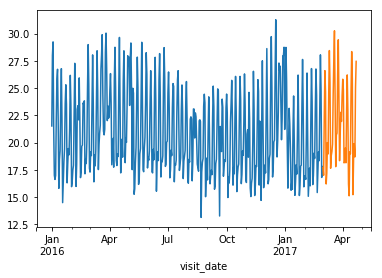

In [30]:
%matplotlib inline
df_train.groupby("visit_date")["visitors"].mean().plot()
df_test.groupby("visit_date")["visitors"].mean().plot()

In [31]:
print(
len(data["tra_as_hol"]["air_area_name"].unique()),
len(data["tra_as_hol"]["longitude"].unique()),
len(data["tra_as_hol"]["latitude"].unique()),
)
print(
len(data["tra_as_hol"].groupby(['latitude', 'longitude']).size()),
len(data["tra_as_hol"].groupby(["air_area_name",'latitude', 'longitude']).size())
)

103 108 108
108 108


For each store I use mean, min, max, std, area, genre, day and holiday as predictors

In [32]:
df_train

,month_0,month_1,month_2,month_3,holiday_flg_0,day_of_week_0,day_of_week_1,day_of_week_2,air_genre_name_0,air_genre_name_1,...,air_area_name_6,air_store_id,visit_date,visitors,latitude,longitude,mean,min,max,std
0,0,0,0,0,0,0,0,0,0,0,...,0,air_ba937bf13d40fb24,2016-01-13,25.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526
1,0,0,0,0,0,0,0,1,0,0,...,0,air_ba937bf13d40fb24,2016-01-14,32.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526
2,0,0,0,0,0,0,1,0,0,0,...,0,air_ba937bf13d40fb24,2016-01-15,29.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526
3,0,0,0,0,0,0,1,1,0,0,...,0,air_ba937bf13d40fb24,2016-01-16,22.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526
4,0,0,0,0,0,1,0,0,0,0,...,0,air_ba937bf13d40fb24,2016-01-18,6.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526
5,0,0,0,0,0,1,0,1,0,0,...,0,air_ba937bf13d40fb24,2016-01-19,9.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526
6,0,0,0,0,0,0,0,0,0,0,...,0,air_ba937bf13d40fb24,2016-01-20,31.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526
7,0,0,0,0,0,0,0,1,0,0,...,0,air_ba937bf13d40fb24,2016-01-21,21.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526
8,0,0,0,0,0,0,1,0,0,0,...,0,air_ba937bf13d40fb24,2016-01-22,18.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526
9,0,0,0,0,0,0,1,1,0,0,...,0,air_ba937bf13d40fb24,2016-01-23,26.0,35.658070,139.751602,22.782608,1.0,61.0,11.810526


In [33]:
def test(df_train,df_test,regr):
    print(df_train.columns)
    X_train = df_train.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    X_test =  df_test.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    # Split the targets into training/testing sets
    y_train = df_train["visitors"].values
    y_test =  df_test["visitors"].values
    print(X_train.shape,y_train.shape)
    print(X_test.shape,y_test.shape)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    error=RMSLE(y_test, y_pred)
    print(error)
    return error

In [34]:
test(df_train,df_test, linear_model.LinearRegression())

Index(['month_0', 'month_1', 'month_2', 'month_3', 'holiday_flg_0',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'air_genre_name_0',
       'air_genre_name_1', 'air_genre_name_2', 'air_genre_name_3',
       'air_area_name_0', 'air_area_name_1', 'air_area_name_2',
       'air_area_name_3', 'air_area_name_4', 'air_area_name_5',
       'air_area_name_6', 'air_store_id', 'visit_date', 'visitors', 'latitude',
       'longitude', 'mean', 'min', 'max', 'std'],
      dtype='object')
(214046, 23) (214046,)
(38062, 23) (38062,)
0.617145367535


0.61714536753490534

## For submission

In [35]:
df_eval

,month_0,month_1,month_2,month_3,holiday_flg_0,day_of_week_0,day_of_week_1,day_of_week_2,air_genre_name_0,air_genre_name_1,...,air_area_name_6,air_store_id,visit_date,visitors,latitude,longitude,mean,min,max,std
391,0,0,1,1,0,1,1,0,0,0,...,0,air_ba937bf13d40fb24,2017-04-23,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526
392,0,0,1,1,0,1,0,0,0,0,...,0,air_ba937bf13d40fb24,2017-04-24,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526
393,0,0,1,1,0,1,0,1,0,0,...,0,air_ba937bf13d40fb24,2017-04-25,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526
394,0,0,1,1,0,0,0,0,0,0,...,0,air_ba937bf13d40fb24,2017-04-26,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526
395,0,0,1,1,0,0,0,1,0,0,...,0,air_ba937bf13d40fb24,2017-04-27,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526
396,0,0,1,1,0,0,1,0,0,0,...,0,air_ba937bf13d40fb24,2017-04-28,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526
397,0,0,1,1,1,0,1,1,0,0,...,0,air_ba937bf13d40fb24,2017-04-29,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526
398,0,0,1,1,0,1,1,0,0,0,...,0,air_ba937bf13d40fb24,2017-04-30,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526
399,0,1,0,0,0,1,0,0,0,0,...,0,air_ba937bf13d40fb24,2017-05-01,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526
400,0,1,0,0,0,1,0,1,0,0,...,0,air_ba937bf13d40fb24,2017-05-02,NaN,35.658070,139.751602,22.782608,1.0,61.0,11.810526


In [38]:
def make_csv(df_train,df_test,df_eval,regr,file):
    df_train_tot=df_train.append(df_test)
    print(df_train_tot.columns)
    print(df_eval.columns)
    X_train = df_train_tot.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    X_test =  df_eval.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    # Split the targets into training/testing sets
    y_train = df_train_tot["visitors"].values
    print(X_train.shape,y_train.shape)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    df_eval["visitors"]=y_pred
    df_eval["id"]=df_eval["air_store_id"].map(str)+"_"+df_eval["visit_date"].dt.strftime('%Y-%m-%d')
    df_sub=df_eval[["id","visitors"]]
    df_sub.to_csv(file,index=False)

In [40]:
df_eval=enc[enc.visitors.isna()]  
make_csv(df_train,df_test,df_eval,linear_model.LinearRegression(),"linear_binary.csv")

Index(['month_0', 'month_1', 'month_2', 'month_3', 'holiday_flg_0',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'air_genre_name_0',
       'air_genre_name_1', 'air_genre_name_2', 'air_genre_name_3',
       'air_area_name_0', 'air_area_name_1', 'air_area_name_2',
       'air_area_name_3', 'air_area_name_4', 'air_area_name_5',
       'air_area_name_6', 'air_store_id', 'visit_date', 'visitors', 'latitude',
       'longitude', 'mean', 'min', 'max', 'std'],
      dtype='object')
Index(['month_0', 'month_1', 'month_2', 'month_3', 'holiday_flg_0',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'air_genre_name_0',
       'air_genre_name_1', 'air_genre_name_2', 'air_genre_name_3',
       'air_area_name_0', 'air_area_name_1', 'air_area_name_2',
       'air_area_name_3', 'air_area_name_4', 'air_area_name_5',
       'air_area_name_6', 'air_store_id', 'visit_date', 'visitors', 'latitude',
       'longitude', 'mean', 'min', 'max', 'std'],
      dtype='object')
(252108, 23) (

/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/baruselli/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
df_eval

In [ ]:
df_eval.columns

In [ ]:
df_test=data["tes"].merge(data["hol"],left_on="time",right_on="calendar_date").\
            drop("time",axis=1).\
            merge(data["as"],right_on="air_store_id",left_on="store_id").\
            drop(["store_id"],axis=1)

In [ ]:
df_test

In [ ]:
df_test["month"]=df_test.calendar_date.map(lambda x: x.month)
df_test["month"]=df_test["month"].astype('category')

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(df_test[cols_to_enc])
#data["tra_as_hol"].join(dummies)
df_test=df_test.join(dummies)
#enc.describe()
df_test=df_test.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in df_test.columns: print(c)
print(len(df_test.columns))

In [ ]:
df_train

### reservations

In [ ]:
#total number of reservations per day, for a stores
data["ar"]["visit_date"]=data["ar"]["visit_datetime"].map(lambda x:x.date())
data["ar"]["visit_date"]=pd.to_datetime(data["ar"]["visit_date"])
#data["ar"].groupby("air_store_id","visit_date")["reserve_visitors"].sum()

#data["ar"]
data["ar_sum"]=data["ar"].groupby(["air_store_id","visit_date"]) ["reserve_visitors"].sum().reset_index()
data["ar_sum"].head()

In [ ]:
#this contains only days with reservations
data["tra_ar_sum"]=data["ar_sum"].merge(data["tra_as_hol"],on=["visit_date","air_store_id"])
data["tra_ar_sum"].head()
df_train

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(data["tra_as_hol"][cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=data["tra_as_hol"].join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)
df_train=enc[enc["visit_date"]<cut_date]
df_test= enc[enc["visit_date"]>= cut_date]

In [ ]:
from sklearn import *
print(df_train.columns)
X_train = df_train.drop(["visitors","visit_date"],axis=1).as_matrix()
X_test =  df_test.drop(["visitors","visit_date"],axis=1).as_matrix()
    # Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred=np.maximum(0,y_pred)
error=RMSLE(y_test, y_pred)
print(error)

In [ ]:
df_store_test[["visitors","visitors_predicted"]]
df_test[["visitors","visitors_predicted"]]

In [ ]:
df_train.columns

In [ ]:
X_train = df_train.drop(["visitors","visit_date"],axis=1).values
X_test =  df_test.drop(["visitors","visit_date"],axis=1).values
# Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values

In [ ]:
y_train

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

### unique stores

In [13]:
data["hr"]

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13
5,hpg_28bdf7a336ec6a7b,2016-01-01 17:00:00,2016-01-01 15:00:00,2
6,hpg_2a01a042bca04ad9,2016-01-01 17:00:00,2016-01-01 17:00:00,2
7,hpg_2a84dd9f4c140b82,2016-01-01 17:00:00,2016-01-01 15:00:00,2
8,hpg_2ad179871696901f,2016-01-01 17:00:00,2016-01-01 13:00:00,2
9,hpg_2c1d989eedb0ff83,2016-01-01 17:00:00,2016-01-01 15:00:00,6


In [14]:
stores_tra=set(data["tra"].air_store_id.unique())
stores_ar=set(data["ar"].air_store_id.unique())
stores_hr=set(data["hr"].hpg_store_id.unique())
stores_as=set(data["as"].air_store_id.unique())
stores_hs=set(data["hs"].hpg_store_id.unique())
stores_id_a=set(data["id"].air_store_id.unique())
stores_id_h=set(data["id"].hpg_store_id.unique())
stores_tes=set(data["tes"].store_id.unique())

In [15]:
stores_tes-stores_tra

set()

In [16]:
print(
    len(stores_tra),len(stores_ar),len(stores_as),len(stores_id_a),"\n",
                    len(stores_hr),len(stores_hs),len(stores_id_h),"\n",
    len(stores_tes))

829 314 829 150 
 13325 4690 150 
 821


In [ ]:
X_train

In [ ]:
df_train.shape,df_test.shape